# DDPM (Diffusion model)

Originally developed for generating and enhancing images, diffusion models have proven highly effective for inpainting tasks. Their iterative denoising process reconstructs missing portions of images, ensuring realistic and aesthetic results. By modeling the process of adding and removing noise, diffusion models seamlessly capture the context and finer details of the image.


## Imports

In [2]:
colab = False

if colab:
    from google.colab import drive
    import os

    drive.mount("/content/drive/")

    colab_path = "/content/drive/MyDrive/"
    os.makedirs(colab_path, exist_ok=True)
    os.chdir(colab_path)
    !pip install pytorch-lightning

In [1]:
import os
import pickle
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pytorch_lightning as pl
import torch
import torch.nn as nn
from PIL import Image
from skimage.metrics import peak_signal_noise_ratio, structural_similarity
from sklearn.metrics import mean_squared_error
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms
from itertools import islice
from diffusers.models.unets import UNet2DModel


/mnt/d/Coding/Python/project-nature-inpainting/.venv/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/mnt/d/Coding/Python/project-nature-inpainting/.venv/lib/python3.11/site-packages/diffusers/models/transformers/transformer_2d.py:34: FutureWarning: `Transformer2DModelOutput` is deprecated and will be removed in version 1.0.0. Importing `Transformer2DModelOutput` from `diffusers.models.transformer_2d` is deprecated and this will be removed in a future version. Please use `from diffusers.models.modeling_outputs import Transformer2DModelOutput`, instead.
  deprecate("Transformer2DModelOutput", "1.0.0", deprecation_message)


In [ ]:
img_loader = 'pickle' # select data loading method.  pickle or jpg

torch.manual_seed(42)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"You will be using {device.type}")

## Data Loading

### Data from JPG

In [3]:
class PairedImagesDataset(Dataset):
    """
    A PyTorch Dataset for loading paired images from directories.

    This Dataset loads paired images (corrupted and original) from directories.
    It applies a transform to the images if provided.

    Attributes
    ----------
    corrupted_dir : Path
        The directory containing the corrupted images.
    original_dir : Path
        The directory containing the original images.
    transform : callable, optional
        An optional transform to apply to the images.
    class_dirs : list
        The list of class directories.
    file_pairs : list
        The list of file pairs.

    Methods
    -------
    __len__()
        Return the number of images in the dataset.
    __getitem__(idx)
        Return the corrupted and original images at the given index.
    """

    def __init__(self, corrupted_dir: Path, original_dir: Path, transform=None):
        """
        Initialize the Dataset.

        Parameters
        ----------
        corrupted_dir : Path
            The directory containing the corrupted images.
        original_dir : Path
            The directory containing the original images.
        transform : callable, optional
            An optional transform to apply to the images.
        """
        self.corrupted_dir = corrupted_dir
        self.original_dir = original_dir
        self.transform = transform
        self.class_dirs = sorted(os.listdir(corrupted_dir))

        # Ensure the two directories have the same number of class directories
        assert len(self.class_dirs) == len(os.listdir(original_dir))

        self.file_pairs = [
            (class_dir, filename)
            for class_dir in self.class_dirs
            for filename in sorted(os.listdir(os.path.join(corrupted_dir, class_dir)))
        ]

    def __len__(self) -> int:
        """
        Return the number of images in the dataset.

        Returns
        -------
        int
            The number of images in the dataset.
        """
        return len(self.file_pairs)

    def __getitem__(self, idx: int) -> tuple[torch.Tensor, torch.Tensor]:
        """
        Return the corrupted and original images at the given index.

        Parameters
        ----------
        idx : int
            The index of the images to return.

        Returns
        -------
        tuple[torch.Tensor, torch.Tensor]
            The corrupted and original images at the given index.
        """
        # Load the corrupted and original images
        class_dir, filename = self.file_pairs[idx]

        # Load the corrupted and original images
        img_corrupted = Image.open(self.corrupted_dir / class_dir / filename)
        img_original = Image.open(self.original_dir / class_dir / filename)

        # Apply the transformations
        if self.transform:
            img_corrupted = self.transform(img_corrupted)
            img_original = self.transform(img_original)

        return img_corrupted, img_original

In [4]:
class PairedImagesDataModule(pl.LightningDataModule):
    """
    A PyTorch Lightning DataModule for loading paired images from directories.

    This DataModule loads paired images (corrupted and original) from directories
    for training, validation, and testing.
    It applies a transform to the images and provides DataLoaders for the datasets.

    Attributes
    ----------
    corrupted_dir : Path
        The directory containing the corrupted images.
    original_dir : Path
        The directory containing the original images.
    batch_size : int
        The batch size for the DataLoaders.
    transform : torchvision.transforms.Compose
        The transform to apply to the images.

    Methods
    -------
    setup(stage=None)
        Prepare the datasets for the given stage.
    train_dataloader()
        Return a DataLoader for the training dataset.
    val_dataloader()
        Return a DataLoader for the validation dataset.
    test_dataloader()
        Return a DataLoader for the test dataset.
    """

    def __init__(self, corrupted_dir: Path, original_dir: Path, batch_size: int = 32):
        """
        Initialize the DataModule.

        Parameters
        ----------
        corrupted_dir : Path
            The directory containing the corrupted images.
        original_dir : Path
            The directory containing the original images.
        batch_size : int, optional
            The batch size for the DataLoaders, by default 32.
        """
        super().__init__()
        self.corrupted_dir = corrupted_dir
        self.original_dir = original_dir
        self.batch_size = batch_size
        self.transform = transforms.Compose(
            [transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))]
        )

    def setup(self, stage=None):
        """
        Prepare the datasets for the given stage.

        This method is called by PyTorch Lightning during the setup stage.
        It prepares the datasets for the given stage (either 'fit', 'test', or None).

        Parameters
        ----------
        stage : str, optional
            The stage for which to prepare the datasets. If 'fit', the method prepares
            the training and validation datasets.
            If 'test', it prepares the test dataset. If None, it prepares all datasets.
        """
        if stage == "fit" or stage is None:
            self.paired_images_train = PairedImagesDataset(
                self.corrupted_dir / "train",
                self.original_dir / "train",
                transform=self.transform,
            )
            self.paired_images_val = PairedImagesDataset(
                self.corrupted_dir / "val",
                self.original_dir / "val",
                transform=self.transform,
            )

        if stage == "test" or stage is None:
            self.paired_images_test = PairedImagesDataset(
                self.corrupted_dir / "test",
                self.original_dir / "test",
                transform=self.transform,
            )

    def train_dataloader(self):
        """
        Return a DataLoader for the training dataset.

        Returns
        -------
        DataLoader
            A DataLoader for the training dataset.
        """
        return DataLoader(
            self.paired_images_train,
            batch_size=self.batch_size,
            shuffle=True,
            num_workers=os.cpu_count(),
        )

    def val_dataloader(self):
        """
        Return a DataLoader for the validation dataset.

        Returns
        -------
        DataLoader
            A DataLoader for the validation dataset.
        """
        return DataLoader(
            self.paired_images_val, batch_size=self.batch_size, num_workers=os.cpu_count()
        )

    def test_dataloader(self):
        """
        Return a DataLoader for the test dataset.

        Returns
        -------
        DataLoader
            A DataLoader for the test dataset.
        """
        return DataLoader(
            self.paired_images_test, batch_size=self.batch_size, num_workers=os.cpu_count()
        )

In [5]:
if img_loader == 'jpg':
    original_dir = Path("data/divided_x64")
    corrupted_dir = Path("data/augmented_x64")

    data_module = PairedImagesDataModule(corrupted_dir, original_dir, batch_size=32)
    data_module.setup()

    train_loader = data_module.train_dataloader()
    val_loader = data_module.val_dataloader()
    test_loader = data_module.test_dataloader()

### Data from Pickle

In [6]:
class PairedImagesDatasetPickle(Dataset):
    """
    A PyTorch Dataset for loading paired images from pickle files.

    This Dataset loads paired images (corrupted and original) from pickle files.
    It applies a transform to the images if provided.

    Attributes
    ----------
    corrupted_file : Path
        The pickle file containing the corrupted images.
    original_file : Path
        The pickle file containing the original images.
    transform : callable, optional
        An optional transform to apply to the images.

    Methods
    -------
    __len__()
        Return the number of images in the dataset.
    __getitem__(idx)
        Return the corrupted and original images at the given index.
    """

    def __init__(self, corrupted_file: Path, original_file: Path, transform=None):
        """
        Initialize the Dataset.

        Parameters
        ----------
        corrupted_file : Path
            The pickle file containing the corrupted images.
        original_file : Path
            The pickle file containing the original images.
        transform : callable, optional
            An optional transform to apply to the images.
        """
        self.corrupted_file = corrupted_file
        self.original_file = original_file
        self.transform = transform

        # Load the images from the pickle files
        with open(corrupted_file, "rb") as f:
            self.corrupted_images = pickle.load(f)
        with open(original_file, "rb") as f:
            self.original_images = pickle.load(f)

        # Ensure the two files have the same number of images
        assert len(self.corrupted_images) == len(self.original_images)

    def __len__(self) -> int:
        """
        Return the number of images in the dataset.

        Returns
        -------
        int
            The number of images in the dataset.
        """
        return len(self.corrupted_images)

    def __getitem__(self, idx: int) -> tuple[torch.Tensor, torch.Tensor]:
        """
        Return the corrupted and original images at the given index.

        Parameters
        ----------
        idx : int
            The index of the images to return.

        Returns
        -------
        tuple[torch.Tensor, torch.Tensor]
            The corrupted and original images at the given index.
        """
        # Load the corrupted and original images
        img_corrupted = self.corrupted_images[idx]
        img_original = self.original_images[idx]

        # Convert the numpy arrays to PIL Images
        img_corrupted = Image.fromarray(img_corrupted)
        img_original = Image.fromarray(img_original)

        # Apply the transformations
        if self.transform:
            img_corrupted = self.transform(img_corrupted)
            img_original = self.transform(img_original)

        return img_corrupted, img_original

In [7]:
class PairedImagesDataModulePickle(pl.LightningDataModule):
    """
    A PyTorch Lightning DataModule for loading paired images from pickle files.

    This DataModule loads paired images (corrupted and original) from pickle files
    for training, validation, and testing.
    It applies a transform to the images and provides DataLoaders for the datasets.

    Attributes
    ----------
    corrupted_dir : Path
        The directory containing the corrupted images pickle files.
    original_dir : Path
        The directory containing the original images pickle files.
    batch_size : int
        The batch size for the DataLoaders.
    transform : torchvision.transforms.Compose
        The transform to apply to the images.

    Methods
    -------
    setup(stage=None)
        Prepare the datasets for the given stage.
    train_dataloader()
        Return a DataLoader for the training dataset.
    val_dataloader()
        Return a DataLoader for the validation dataset.
    test_dataloader()
        Return a DataLoader for the test dataset.
    """

    def __init__(self, corrupted_dir: Path, original_dir: Path, batch_size: int = 32):
        """
        Initialize the DataModule.

        Parameters
        ----------
        corrupted_dir : Path
            The directory containing the corrupted images in pickle files.
        original_dir : Path
            The directory containing the original images in pickle files.
        batch_size : int, optional
            The batch size for the DataLoaders, by default 32.
        """
        super().__init__()
        self.corrupted_dir = corrupted_dir
        self.original_dir = original_dir
        self.batch_size = batch_size
        self.transform = transforms.Compose(
            [transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))]
        )

    def setup(self, stage=None):
        """
        Prepare the datasets for the given stage.

        This method is called by PyTorch Lightning during the setup stage.
        It prepares the datasets for the given stage (either 'fit', 'test', or None).

        Parameters
        ----------
        stage : str, optional
            The stage for which to prepare the datasets. If 'fit', the method prepares
            the training and validation datasets.
            If 'test', it prepares the test dataset. If None, it prepares all datasets.
        """
        if stage == "fit" or stage is None:
            self.paired_images_train = PairedImagesDatasetPickle(
                self.corrupted_dir / "train.pkl",
                self.original_dir / "train.pkl",
                transform=self.transform,
            )
            self.paired_images_val = PairedImagesDatasetPickle(
                self.corrupted_dir / "val.pkl",
                self.original_dir / "val.pkl",
                transform=self.transform,
            )

        if stage == "test" or stage is None:
            self.paired_images_test = PairedImagesDatasetPickle(
                self.corrupted_dir / "test.pkl",
                self.original_dir / "test.pkl",
                transform=self.transform,
            )

    def train_dataloader(self):
        """
        Return a DataLoader for the training dataset.

        Returns
        -------
        DataLoader
            A DataLoader for the training dataset.
        """
        return DataLoader(
            self.paired_images_train,
            batch_size=self.batch_size,
            shuffle=True,
            num_workers=os.cpu_count(),
            pin_memory=True,
        )

    def val_dataloader(self):
        """
        Return a DataLoader for the validation dataset.

        Returns
        -------
        DataLoader
            A DataLoader for the validation dataset.
        """
        return DataLoader(
            self.paired_images_val,
            batch_size=self.batch_size,
            num_workers=os.cpu_count(),
            pin_memory=True,
            shuffle=True,
        )

    def test_dataloader(self):
        """
        Return a DataLoader for the test dataset.

        Returns
        -------
        DataLoader
            A DataLoader for the test dataset.
        """
        return DataLoader(
            self.paired_images_test,
            batch_size=self.batch_size,
            num_workers=os.cpu_count(),
            pin_memory=True,
            shuffle=True,
        )

In [8]:
if img_loader == 'pickle':
    original_dir = Path("data/divided_x64")
    corrupted_dir = Path("data/augmented_x64")

    data_module_pickle = PairedImagesDataModulePickle(
        corrupted_dir, original_dir, batch_size=32
    )
    data_module_pickle.setup()

    train_loader = data_module_pickle.train_dataloader()
    val_loader = data_module_pickle.val_dataloader()
    test_loader = data_module_pickle.test_dataloader()


## DDPM model

### UNNet model

In [9]:
class UNetDDPM(torch.nn.Module):
    """
    A UNet-based Denoising Diffusion Probabilistic Model (DDPM) for image generation.

    This model architecture is based on a UNet structure, utilizing ResNet blocks
    for both downsampling and upsampling paths. It optionally includes attention
    mechanisms to enhance feature representation.

    Parameters
    ----------
    channels : list of int
        The number of channels for each block in the UNet architecture. Defines the
        depth and capacity of the model.
    """
    def __init__(self, channels=[32, 64, 96, 128]):
        """
        Initializes the UNet-based Denoising Diffusion Probabilistic Model (DDPM) component.

        Parameters
        ----------
        channels : list of int, optional
            A list specifying the number of channels for each block in the UNet architecture.
            This defines the depth and capacity of the model. The default configuration is [32, 64, 96, 128].
        """
        super().__init__()
        self.channels = channels
        self.layers_per_block = 2
        self.downblock = 'ResnetDownsampleBlock2D'
        self.upblock = 'ResnetUpsampleBlock2D'
        self.add_attention = True
        self.attention_head_dim = 32

        self.unet = UNet2DModel(
            in_channels=6,
            out_channels=3,
            block_out_channels=self.channels, 
            layers_per_block=self.layers_per_block,
            down_block_types=tuple(self.downblock for _ in range(len(self.channels))),
            up_block_types=tuple(self.upblock for _ in range(len(self.channels))),
            add_attention=self.add_attention, 
            attention_head_dim=self.attention_head_dim,
        )

    def forward(self, x_t, img_crop, t):
        """
        Forward pass of the UNet-based DDPM model.

        Parameters
        ----------
        x_t : torch.Tensor
            The current state of the image being processed, with noise added. This tensor should have
            a shape compatible with the input requirements of the UNet model, typically including dimensions
            for batch size, channels, height, and width.
        img_crop : torch.Tensor
            A cropped image for conditional generation. This tensor should have the
            same height and width dimensions as `x_t` and will be concatenated along the channel dimension.
        t : torch.Tensor
            The current timestep or noise level in the diffusion process. This should be a single-dimensional
            tensor with the same batch size as `x_t` and `img_crop`.

        Returns
        -------
        torch.Tensor
            The generated image at the current timestep. The output tensor will have the same shape as `x_t`,
            representing the denoised image state.
        """
        return self.unet(
            torch.cat([x_t, img_crop], dim=1),
            timestep=t.float() # pomyśleć jak to zastąpić alphą
        ).sample# + x

In [10]:
unet_model = UNetDDPM([ 64, 96, 128])

# show num of parameters
num_params = sum(p.numel() for p in unet_model.parameters())
print(f'Number of parameters: {num_params}')

Number of parameters: 5580131


### Beta sheduler

In [11]:
import math
def beta_schedule_linear(num_diffusion_timesteps):
    """
    Generates a linear beta schedule for the diffusion process.

    Parameters
    ----------
    num_diffusion_timesteps : int
        The total number of timesteps in the diffusion process. This determines the length of the
        beta schedule array.

    Returns
    -------
    np.ndarray
        An array of beta values for each timestep in the diffusion process. The array has a length
        equal to `num_diffusion_timesteps` and contains float64 values.

    """
    scale = 1000 / num_diffusion_timesteps
    beta_start = scale * 0.0001
    beta_end = scale * 0.02
    return np.linspace(
        beta_start**0.5, beta_end**0.5, num_diffusion_timesteps, dtype=np.float64
    ) ** 2
    

def beta_schedule_cosine(num_diffusion_timesteps):
    """
    Generates a cosine beta schedule for the diffusion process.


    Parameters
    ----------
    num_diffusion_timesteps : int
        The total number of timesteps in the diffusion process. This determines the length of the
        beta schedule array.

    Returns
    -------
    np.ndarray
        An array of beta values for each timestep in the diffusion process. The array has a length
        equal to `num_diffusion_timesteps` and contains float64 values.

    """
    betas = []
    for i in range(num_diffusion_timesteps):
        max_beta=0.999
        t1 = float(i) / num_diffusion_timesteps
        t2 = float(i + 1) / num_diffusion_timesteps
        alpha = lambda t: math.cos((t + 0.008) / 1.008 * math.pi / 2) ** 2
        betas.append(min(1 - alpha(t2) / alpha(t1), max_beta))
    return np.array(betas)
    
    
def apply(factors, timesteps, x, multiply=True):
    """
    Extract values from factors with certain timesteps and apply them to x.

    Parameters
    ----------
    factors : numpy.ndarray
        A 1-dimensional numpy array from which values are extracted.
    timesteps : torch.Tensor
        A tensor of indices into the `factors` array to extract values from. These indices correspond
        to specific timesteps in a process.
    x : torch.Tensor
        A tensor to which the extracted values are applied. This tensor should have a larger shape,
        typically with its first dimension (batch dimension) equal to the length of `timesteps`.
    multiply : bool, optional
        A flag determining the mode of application of the extracted values to `x`. If True (default),
        the extracted values are multiplied with `x`. If False, the extracted values are expanded to
        match the shape of `x` without multiplication.

    Returns
    -------
    torch.Tensor
        A tensor resulting from the application of the extracted values to `x`. If `multiply` is True,
        this tensor is the product of `x` and the extracted values, expanded to match the shape of `x`.
        If `multiply` is False, it is the extracted values expanded to match the shape of `x`. The
        returned tensor has the same number of dimensions as `x`, with the first dimension (batch size)
        equal to the length of `timesteps`.

    """
    res = torch.from_numpy(factors).to(device=timesteps.device)[timesteps].float()
    while len(res.shape) < len(x.shape):
        res = res[..., None]
    return (res.expand(x.shape) * x) if multiply else res.expand(x.shape)

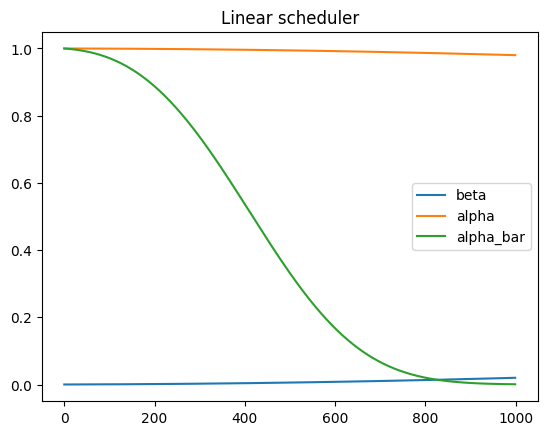

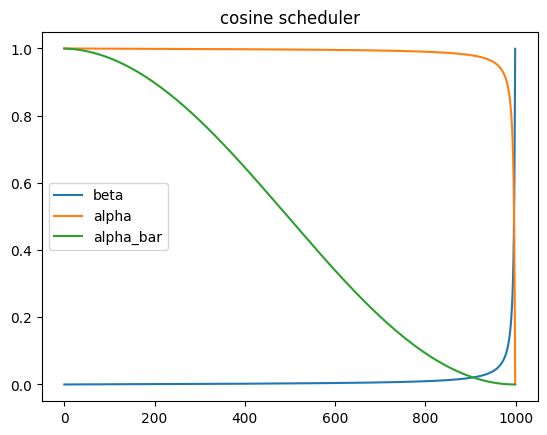

In [12]:
# beta = get_named_beta_schedule("linear", 1000)
beta = beta_schedule_linear(1000)
alpha = 1 - beta
alpha_bar = np.cumprod(alpha)

plt.plot(beta, label='beta')
plt.plot(alpha, label='alpha')
plt.plot(alpha_bar, label='alpha_bar')

plt.legend()
plt.title("Linear scheduler")

plt.show()

beta = beta_schedule_cosine(1000)
alpha = 1 - beta
alpha_bar = np.cumprod(alpha)

plt.plot(beta, label='beta')
plt.plot(alpha, label='alpha')
plt.plot(alpha_bar, label='alpha_bar')

plt.legend()
plt.title("cosine scheduler")

plt.show()

### Diffusion model

In [13]:
class Diffusion:
    """
    Implements a diffusion process for generating images.

    Parameters
    ----------
    timesteps : int, optional
        The number of timesteps in the diffusion process. Defaults to 1000.
    beta_type : str, optional
        The type of beta schedule to use. Can be 'cosine' or 'linear'. Defaults to 'cosine'.

    """
    def __init__(self, timesteps=1000, beta_type='cosine'):
        """
        Initializes the diffusion process with specified timesteps and beta schedule.

        Parameters
        ----------
        timesteps : int, optional
            The number of timesteps for the diffusion process. Defaults to 1000.
        beta_type : str, optional
            The type of schedule to use for the beta values. Can be 'cosine' or 'linear'.
            Defaults to 'cosine'.
        """
        self.timesteps = timesteps
        if beta_type == 'cosine':
            self.beta = beta_schedule_cosine(self.timesteps)
        elif beta_type == 'linear':
            self.beta = beta_schedule_linear(self.timesteps)
        self.alpha = 1 - self.beta
        self.alpha_bar = np.cumprod(self.alpha)
        self.alpha_bar_prev = np.concatenate([np.array([1]), self.alpha_bar[:-1]])

    def forward(self, x_0, t, epsilon=None):
        """
        Performs the forward pass of the diffusion process, adding noise to an image.

        Parameters
        ----------
        x_0 : torch.Tensor
            The original image tensor.
        t : torch.Tensor
            The tensor containing the timestep `t` for each image in the batch. This determines the
            amount of noise to add to each image.
        epsilon : torch.Tensor, optional
            An external noise tensor. If None, noise is sampled internally using `torch.randn_like`.

        Returns
        -------
        torch.Tensor
            The noised image tensor at timestep `t`.
        """
        if epsilon is None:
            epsilon = torch.randn_like(x_0)

        x_t = apply(np.sqrt(self.alpha_bar), t, x_0) + apply(np.sqrt(1 - self.alpha_bar), t, epsilon) # we add noise to x_0
        return x_t


    def compute_loss(self, unet, x_0, img_crop):
        """
        Computes the loss for a batch of images using a U-Net model.

        Parameters
        ----------
        unet : torch.nn.Module
            The U-Net model used for predicting the original images from their noised versions.
        x_0 : torch.Tensor
            The original images tensor.
        img_crop : torch.Tensor
            The cropped images tensor used as additional input to the U-Net model.

        Returns
        -------
        torch.Tensor
            The computed loss, averaged over the batch.
        """
        
        timesteps = torch.randint(0, self.timesteps, (x_0.shape[0],), device=x_0.device, dtype=torch.long)
        epsilon = torch.randn_like(x_0, device=x_0.device, dtype=x_0.dtype)
        x_t = self.forward(x_0, timesteps, epsilon)
        
        
        pred_x_0 = unet(x_t, img_crop, timesteps)
        mse = (pred_x_0 - x_0).pow(2).mean(dim=(1,2,3)) # loss
        loss = apply(np.sqrt(self.alpha_bar), timesteps, mse).mean()

        return loss
    
    def posterior(self, x_t, x_0, t, epsilon=None):
        """
        Computes the posterior estimate of the original image given a noised image at timestep t.

        Parameters
        ----------
        x_t : torch.Tensor
            The noised image tensor at timestep t.
        x_0 : torch.Tensor
            The original image tensor.
        t : torch.Tensor
            The tensor containing the timestep t for each image in the batch.
        epsilon : torch.Tensor, optional
            An external noise tensor. If None, noise is sampled internally.

        Returns
        -------
        torch.Tensor
            The posterior estimate of the original image tensor.
        """
        if epsilon is None:
            epsilon = torch.randn_like(x_0)

        x_prev = ( 
            apply((np.sqrt(self.alpha_bar_prev)*self.beta) / (1 - self.alpha_bar), t, x_0) + 
            apply((np.sqrt(self.alpha) * (1 - self.alpha_bar_prev)) / (1 - self.alpha_bar), t, x_t) + 
            apply(np.sqrt((1 - self.alpha_bar_prev) / (1 - self.alpha_bar) * self.beta), t, epsilon)
        )

        return x_prev

    def sample(self, unet, img_crop, sample_size=(1, 3, 64, 64)):
        """
        Generates new images by sampling from the learned distribution using a U-Net model.

        Parameters
        ----------
        unet : torch.nn.Module
            The U-Net model used for predicting the denoised images at each reverse timestep.
        img_crop : torch.Tensor
            The cropped images tensor used as additional input to the U-Net model.
        sample_size : tuple of int, optional
            The size of the tensor to be sampled, formatted as (batch_size, channels, height, width).
            Defaults to (1, 3, 64, 64).

        Returns
        -------
        torch.Tensor
            The tensor of generated images, detached and moved to CPU.
        """
        with torch.no_grad():
            x_t = torch.randn(sample_size, device=unet.unet.device)
            
            timesteps = list(range(self.timesteps))[::-1]

            print('\nsampling loop')

            for i in timesteps:
                t = torch.Tensor([i] * x_t.shape[0]).long().to(x_t.device)

                pred_x_0 = torch.clamp(unet(x_t, img_crop, t), -1, 1)

                if i > 0:
                    x_t = self.posterior(x_t, pred_x_0, t)
                    
                else:
                    x_t = pred_x_0

        return x_t.detach().cpu()
    

tensor(-1.) tensor(1.)
tensor(-1.2642) tensor(1.2767)


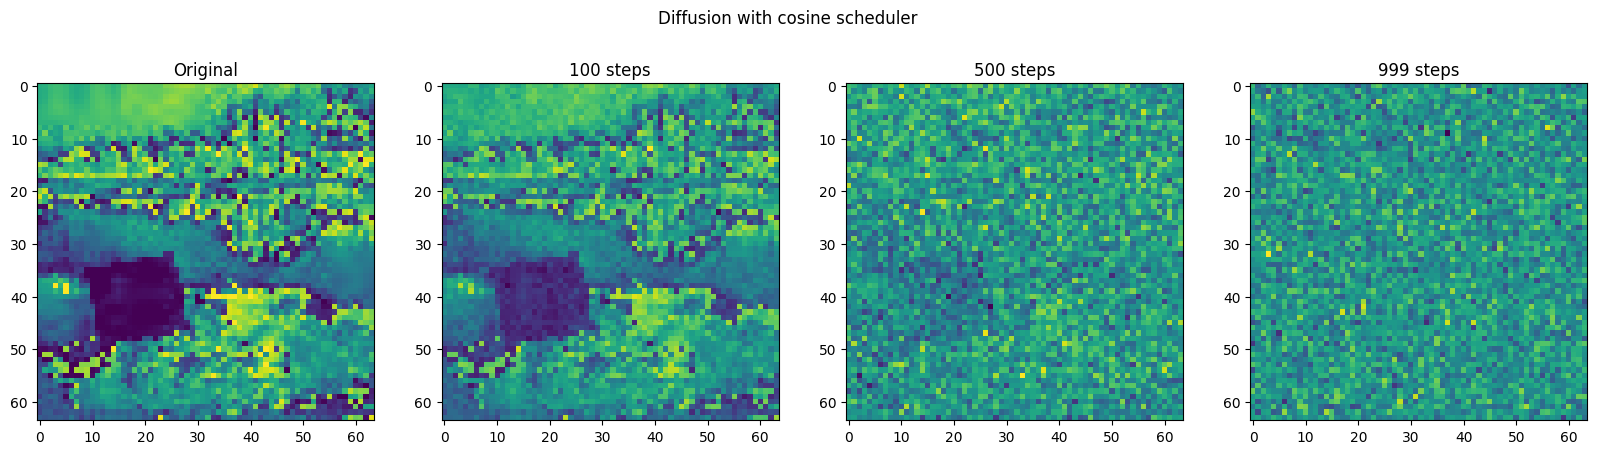

tensor(-1.2768) tensor(1.2261)


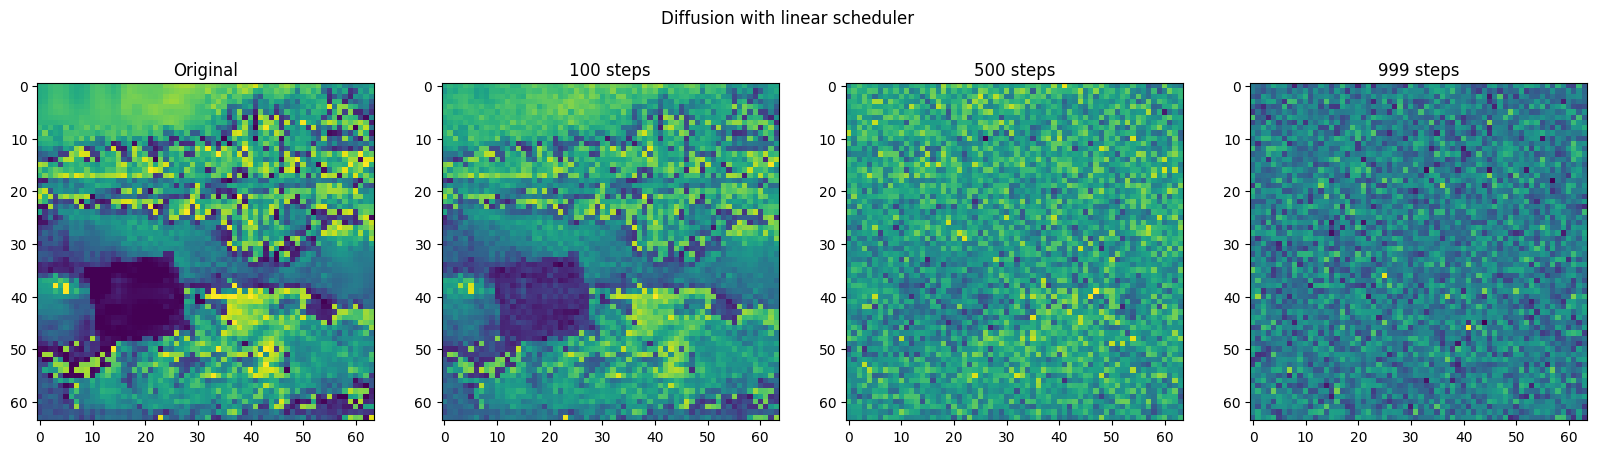

In [14]:
batch = next(iter(train_loader))
img = batch[0][0]

print(img.min(), img.max())

for scheduler in ['cosine', 'linear']:
    diffusion = Diffusion(timesteps=1000)

    x_1 = (diffusion.forward(2*img-1, torch.tensor([100])) + 1.0) * 0.5
    x_2 = (diffusion.forward(img, torch.tensor([500])) + 1.0) * 0.5
    x_3 = (diffusion.forward(img, torch.tensor([999])) + 1.0) * 0.5
    print(x_1.min(), x_1.max())
    # plot original and diffused image in subplots
    fig, axs = plt.subplots(1, 4, figsize=(20, 5))
    axs[0].imshow(img[0])
    axs[0].set_title('Original')
    axs[1].imshow(x_1[0])
    axs[1].set_title('100 steps')
    axs[2].imshow(x_2[0])
    axs[2].set_title('500 steps')
    axs[3].imshow(x_3[0])
    axs[3].set_title('999 steps')
    plt.suptitle(f'Diffusion with {scheduler} scheduler')
    plt.show()


### DDPM

In [21]:
class DDPM(pl.LightningModule):
    """
    A PyTorch Lightning module for training and validating a model with a diffusion process.

    Parameters
    ----------
    unet_model : torch.nn.Module
        The U-Net model to be trained.
    diffusion : Diffusion
        The diffusion process to be used for generating and denoising images.
    lr : float, optional
        The learning rate for the optimizer. Default is 1e-4.
    """
    
    def __init__(self, unet_model, diffusion, lr=1e-4):
        """
        Initializes the ModelLit module with a U-Net model, a diffusion process, and a learning rate.
        """
        super().__init__()
        self.unet = unet_model
        self.diffusion = diffusion
        self.lr = lr
        self.loss_log = []

    def forward(self, x, t):
        """
        Placeholder for the forward pass. Raises NotImplementedError.
        
        Parameters
        ----------
        x : torch.Tensor
            The input tensor.
        t : torch.Tensor
            The tensor containing the timestep for each input in the batch.

        Raises
        ------
        NotImplementedError
            If the method is not overridden in a subclass.
        """
        raise NotImplementedError('Forward method is not implemented')

    def training_step(self, batch, batch_idx):
        """
        Performs a single training step.

        Parameters
        ----------
        batch : tuple
            A tuple containing the input batch. It includes the cropped images and the original images.
        batch_idx : int
            The index of the current batch.

        Returns
        -------
        torch.Tensor
            The computed loss for the batch.
        """
        crop_img, x_0 = batch

        loss = self.diffusion.compute_loss(self.unet, x_0, crop_img)
        self.log('train_loss', loss, on_step=True, on_epoch=True, prog_bar=True, logger=True)
        return loss

    def validation_step(
        self, batch: tuple[torch.Tensor, torch.Tensor], batch_idx: int
    ) -> dict:
        """
        Performs a validation step and visualizes predictions.

        This method generates images using the diffusion process and compares them with the ground
        truth images. It visualizes a subset of the generated and ground truth images.

        Parameters
        ----------
        batch : tuple[torch.Tensor, torch.Tensor]
            The input and target tensors for the batch.
        batch_idx : int
            The index of the batch.

        Returns
        -------
        dict
            A dictionary with the loss for the step.
        """
        img_crop, x_0 = batch
        img_crop, x_0 = img_crop.to(self.device), x_0.to(self.device)
        shape = img_crop.shape
        pred_x_0 = self.diffusion.sample(self.unet, img_crop, sample_size=shape)
        
        fig, axs = plt.subplots(2, 5, figsize=(10, 4))
        for i in range(5):
            num = np.random.randint(0, shape[0])
            
            pred_x_0_plot  = torch.clip(pred_x_0[num], -1, 1)
            pred_x_0_plot = pred_x_0_plot.detach().cpu().numpy().transpose(1, 2, 0)
            pred_x_0_plot = (pred_x_0_plot + 1) / 2  # Normalize to [0, 1]
            
            x_0_true = x_0[num].detach().cpu().numpy().transpose(1, 2, 0)
            x_0_true = (x_0_true + 1) / 2  # Normalize to [0, 1]
            
            axs[0, i].imshow(x_0_true)
            axs[0, i].set_title("Ground Truth x_0")
            axs[0, i].set_xticks([])
            axs[0, i].set_yticks([])
            axs[1, i].imshow(pred_x_0_plot)
            axs[1, i].set_title("Predicted x_0")
            axs[1, i].set_xticks([])
            axs[1, i].set_yticks([])
        plt.suptitle(f"Epoch {self.current_epoch}")
        plt.show()
    
        # self.loss_log.append(self.diffusion.compute_loss(self.unet, x_0, img_crop).item())
    
    def configure_optimizers(self):
        """
        Configures the optimizer for the model.

        Returns
        -------
        torch.optim.Optimizer
            The configured optimizer.
        """
        optimizer = torch.optim.Adam(self.unet.parameters(), lr=self.lr)
        return optimizer

In [ ]:
def evaluate(model: nn.Module, test_loader: DataLoader, n:int = 10, device:str = 'cuda') -> None:
    """
    Evaluate the model on a test dataset and display the results.

    This function computes the MSE, NRMSE, PSNR, and SSIM metrics for the model's predictions
    on the test dataset. It also displays the corrupted, predicted, and ground truth images
    for the first 5 samples in the test dataset.

    Parameters
    ----------
    model : nn.Module
        The model to evaluate.
    test_loader : DataLoader
        The DataLoader for the test dataset.
    n : int
        Optional parameter for limiting how many batches will be used to evaluate the model.

    Returns
    -------
    pd.DataFrame
        A DataFrame with the computed metrics for each sample in the test dataset.
    """
    model.eval()
    model = model.to(device)
    fig, axs = plt.subplots(3, 5, figsize=(15, 15))
    metrics = {"MSE": [], "NRMSE": [], "PSNR": [], "SSIM": []}
    with torch.no_grad():
        for idx, (img_crop, x_0) in enumerate(islice(test_loader, n)):
            # print(idx)
            
            img_crop, x_0 = img_crop.to(model.device), x_0.to(model.device)
            
            x_0_pred = model.diffusion.sample(model.unet, img_crop, sample_size=img_crop.shape)
            x_0_pred = x_0_pred[0].detach().cpu().numpy().transpose(1, 2, 0)
            x_0_pred = (x_0_pred + 1) / 2
            x_0 = x_0[0].detach().cpu().numpy().transpose(1, 2, 0)
            x_0 = (x_0 + 1) / 2
            img_crop = img_crop[0].detach().cpu().numpy().transpose(1, 2, 0)
            img_crop = (img_crop + 1) / 2
            mse = mean_squared_error(x_0.flatten(), x_0_pred.flatten())
            nrmse = np.sqrt(mse) / (np.max(x_0) - np.min(x_0))
            psnr = peak_signal_noise_ratio(x_0, x_0_pred, data_range=x_0.max() - x_0.min())
            ssim = structural_similarity(
                x_0, x_0_pred, channel_axis=-1, data_range=x_0.max() - x_0.min()
            )
            metrics["MSE"].append(mse)
            metrics["NRMSE"].append(nrmse)
            metrics["PSNR"].append(psnr)
            metrics["SSIM"].append(ssim)
            if idx < 5:
                axs[0, idx].imshow(img_crop)
                axs[0, idx].set_title("Corrupted Image")
                axs[1, idx].imshow(x_0_pred)
                axs[1, idx].set_title("Predicted")
                axs[2, idx].imshow(x_0)
                axs[2, idx].set_title("Ground Truth")

    plt.show()

    metrics_df = pd.DataFrame(metrics)
    summary = metrics_df.describe()
    mean_min_summary = summary.loc[["max", "mean", "min"]]
    display(mean_min_summary)

    return metrics_df

## Train and Evaluate

In [ ]:
%load_ext tensorboard

%tensorboard --logdir lightning_logs/

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
`Trainer(limit_val_batches=1)` was configured so 1 batch will be used.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name | Type     | Params
----------------------------------
0 | unet | UNetDDPM | 5.6 M 
----------------------------------
5.6 M     Trainable params
0         Non-trainable params
5.6 M     Total params
22.321    Total estimated model params size (MB)


Sanity Checking DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]
sampling loop


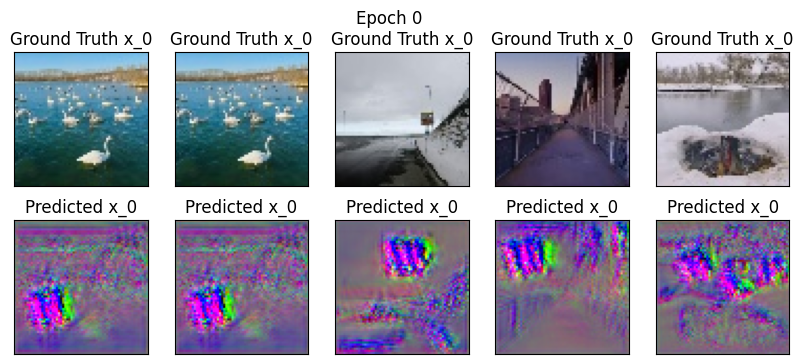

Epoch 0: 100%|██████████| 1894/1894 [03:19<00:00,  9.50it/s, v_num=44, train_loss_step=0.00344]
sampling loop


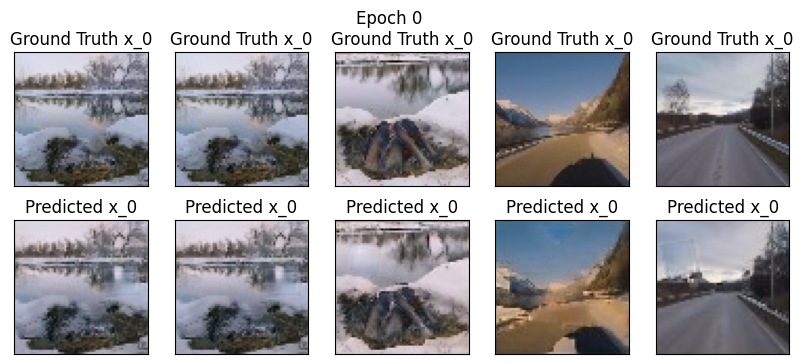

Epoch 1: 100%|██████████| 1894/1894 [03:16<00:00,  9.62it/s, v_num=44, train_loss_step=0.00808, train_loss_epoch=0.0108]
sampling loop


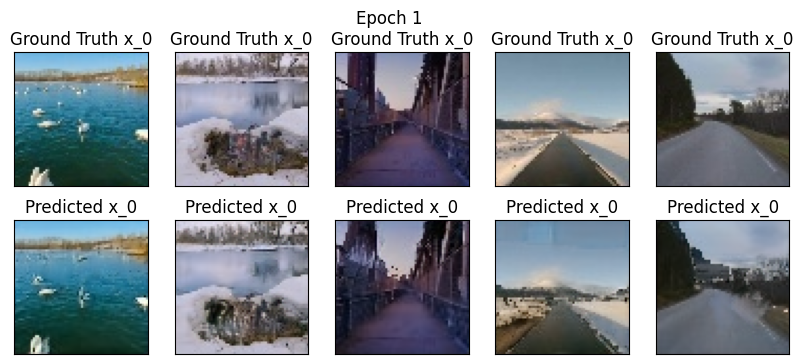

Epoch 2: 100%|██████████| 1894/1894 [03:16<00:00,  9.62it/s, v_num=44, train_loss_step=0.00392, train_loss_epoch=0.00447]
sampling loop


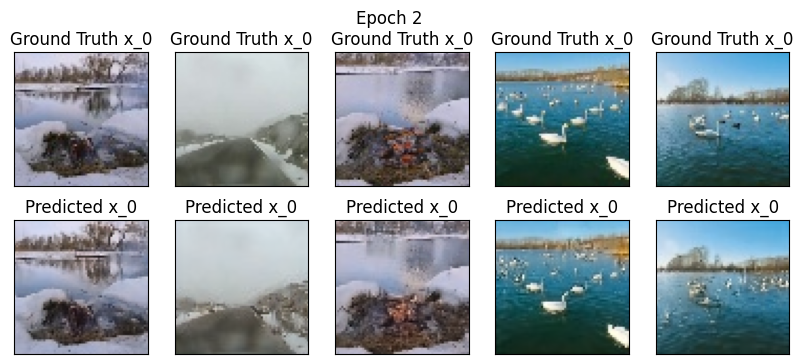

Epoch 3: 100%|██████████| 1894/1894 [03:17<00:00,  9.60it/s, v_num=44, train_loss_step=0.00574, train_loss_epoch=0.00361]
sampling loop


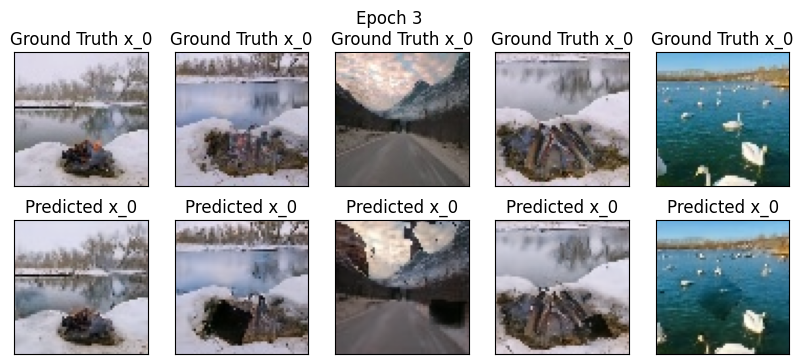

Epoch 4: 100%|██████████| 1894/1894 [03:16<00:00,  9.62it/s, v_num=44, train_loss_step=0.00448, train_loss_epoch=0.00321]
sampling loop


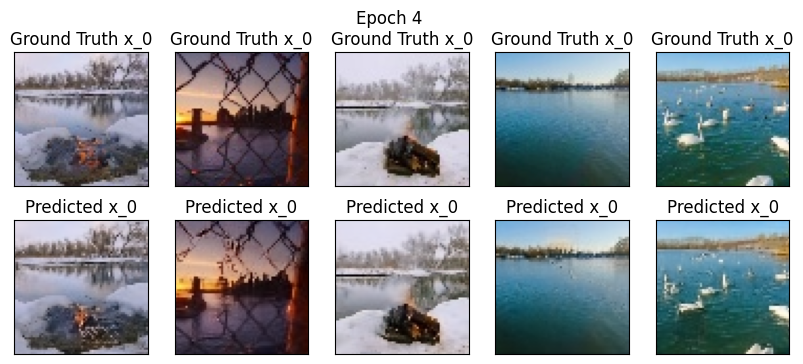

Epoch 5: 100%|██████████| 1894/1894 [03:17<00:00,  9.59it/s, v_num=44, train_loss_step=0.00388, train_loss_epoch=0.00293]
sampling loop


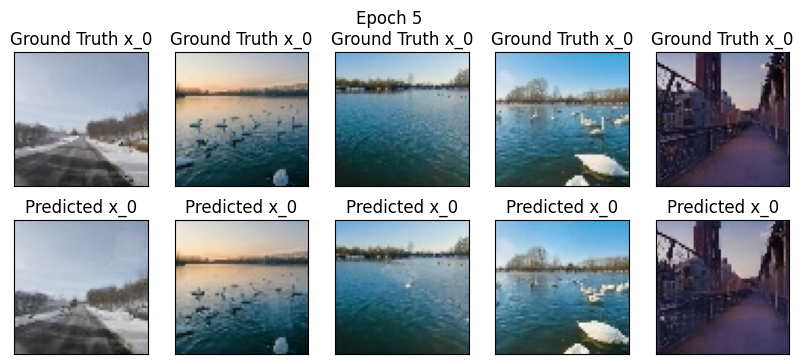

Epoch 6: 100%|██████████| 1894/1894 [03:19<00:00,  9.51it/s, v_num=44, train_loss_step=0.0024, train_loss_epoch=0.00281] 
sampling loop


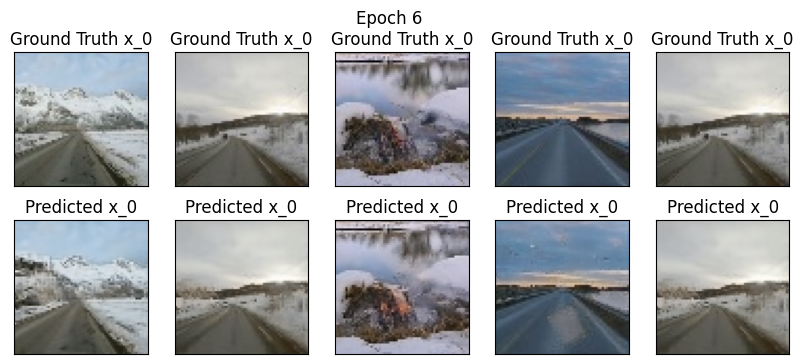

Epoch 7: 100%|██████████| 1894/1894 [03:19<00:00,  9.49it/s, v_num=44, train_loss_step=0.00137, train_loss_epoch=0.00261]
sampling loop


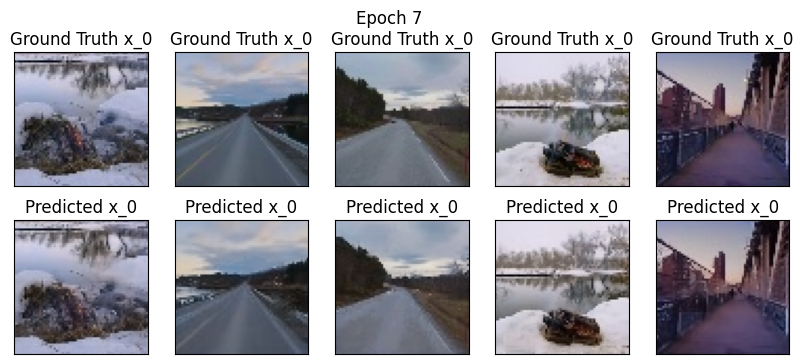

Epoch 8: 100%|██████████| 1894/1894 [03:20<00:00,  9.44it/s, v_num=44, train_loss_step=0.00185, train_loss_epoch=0.00248]
sampling loop


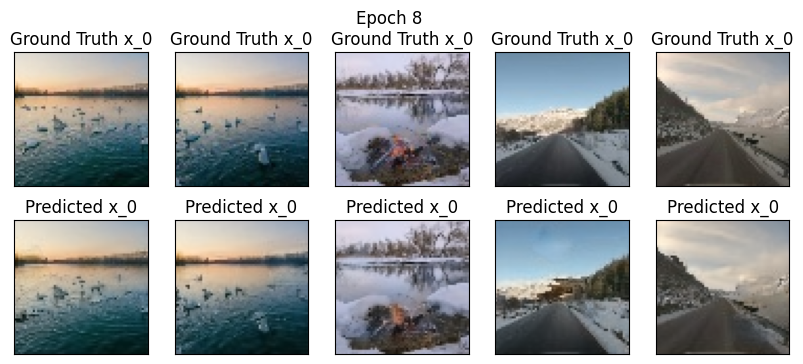

Epoch 9: 100%|██████████| 1894/1894 [03:20<00:00,  9.45it/s, v_num=44, train_loss_step=0.00235, train_loss_epoch=0.00238]
sampling loop


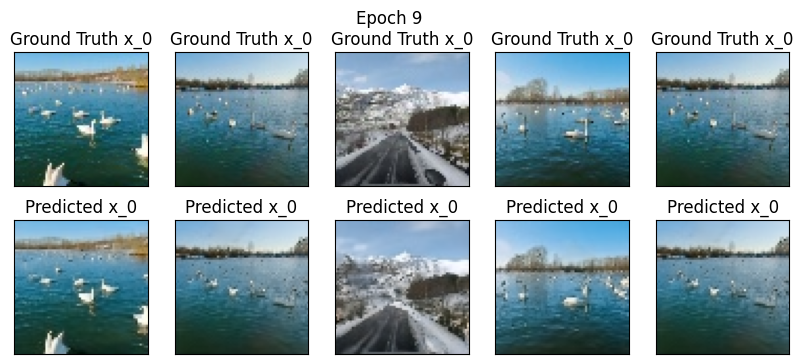

Epoch 10: 100%|██████████| 1894/1894 [03:20<00:00,  9.46it/s, v_num=44, train_loss_step=0.00271, train_loss_epoch=0.00232]
sampling loop


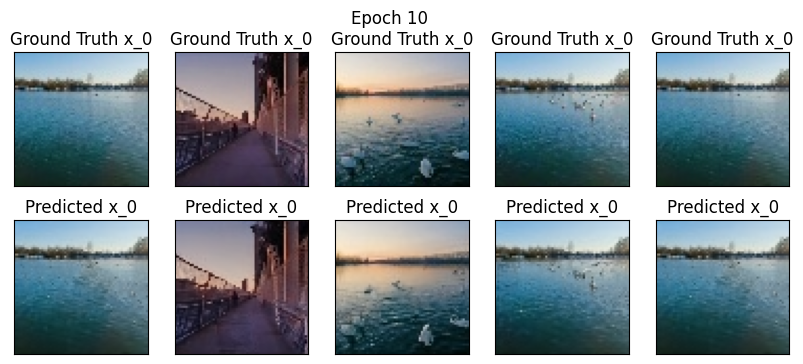

Epoch 11: 100%|██████████| 1894/1894 [03:20<00:00,  9.46it/s, v_num=44, train_loss_step=0.00202, train_loss_epoch=0.00222]
sampling loop


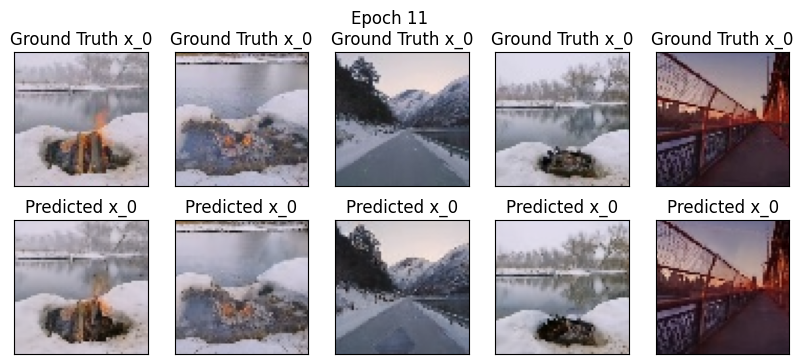

Epoch 12: 100%|██████████| 1894/1894 [03:16<00:00,  9.66it/s, v_num=44, train_loss_step=0.00279, train_loss_epoch=0.00217]
sampling loop


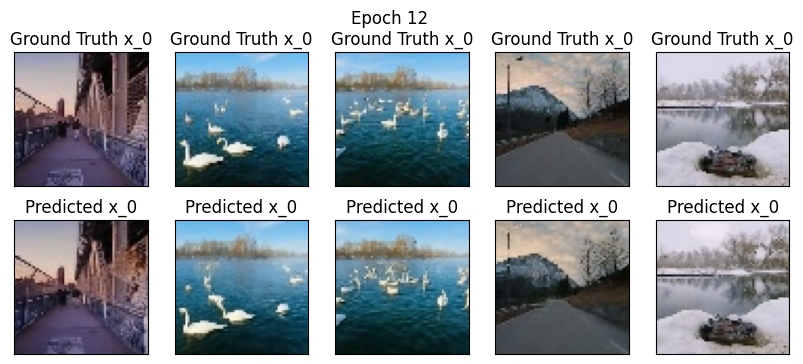

Epoch 13: 100%|██████████| 1894/1894 [03:15<00:00,  9.69it/s, v_num=44, train_loss_step=0.00267, train_loss_epoch=0.00213]
sampling loop


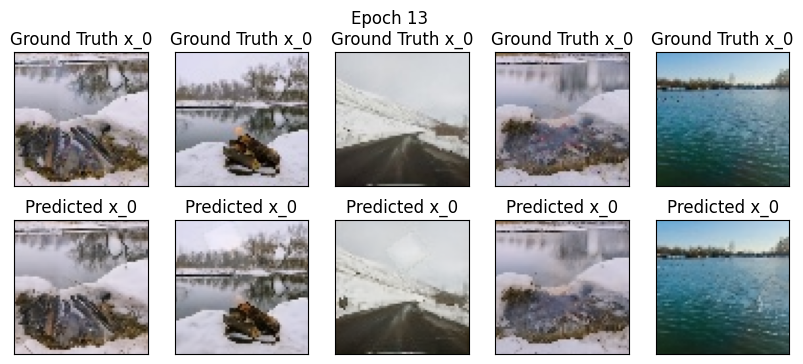

Epoch 14: 100%|██████████| 1894/1894 [03:15<00:00,  9.70it/s, v_num=44, train_loss_step=0.000303, train_loss_epoch=0.00205]
sampling loop


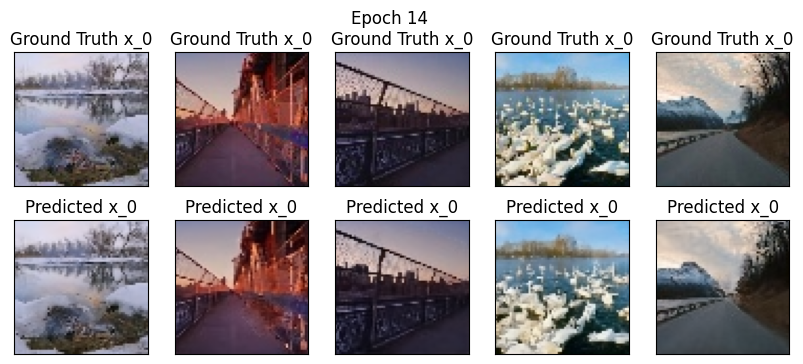

Epoch 14: 100%|██████████| 1894/1894 [03:46<00:00,  8.35it/s, v_num=44, train_loss_step=0.000303, train_loss_epoch=0.00201]

`Trainer.fit` stopped: `max_epochs=15` reached.


Epoch 14: 100%|██████████| 1894/1894 [03:47<00:00,  8.34it/s, v_num=44, train_loss_step=0.000303, train_loss_epoch=0.00201]


In [22]:
diffusion = Diffusion(timesteps=1000, beta_type='cosine')
unet_model = UNetDDPM(channels=[64, 96, 128])
ddpm_model = DDPM(unet_model, diffusion)

trainer = pl.Trainer(
    devices=[0],
    max_epochs=15, 
    check_val_every_n_epoch=1,
    limit_val_batches=1,
    )

trainer.fit(
    model=ddpm_model, 
    train_dataloaders=train_loader, 
    val_dataloaders=val_loader,
    )


sampling loop

sampling loop

sampling loop

sampling loop

sampling loop


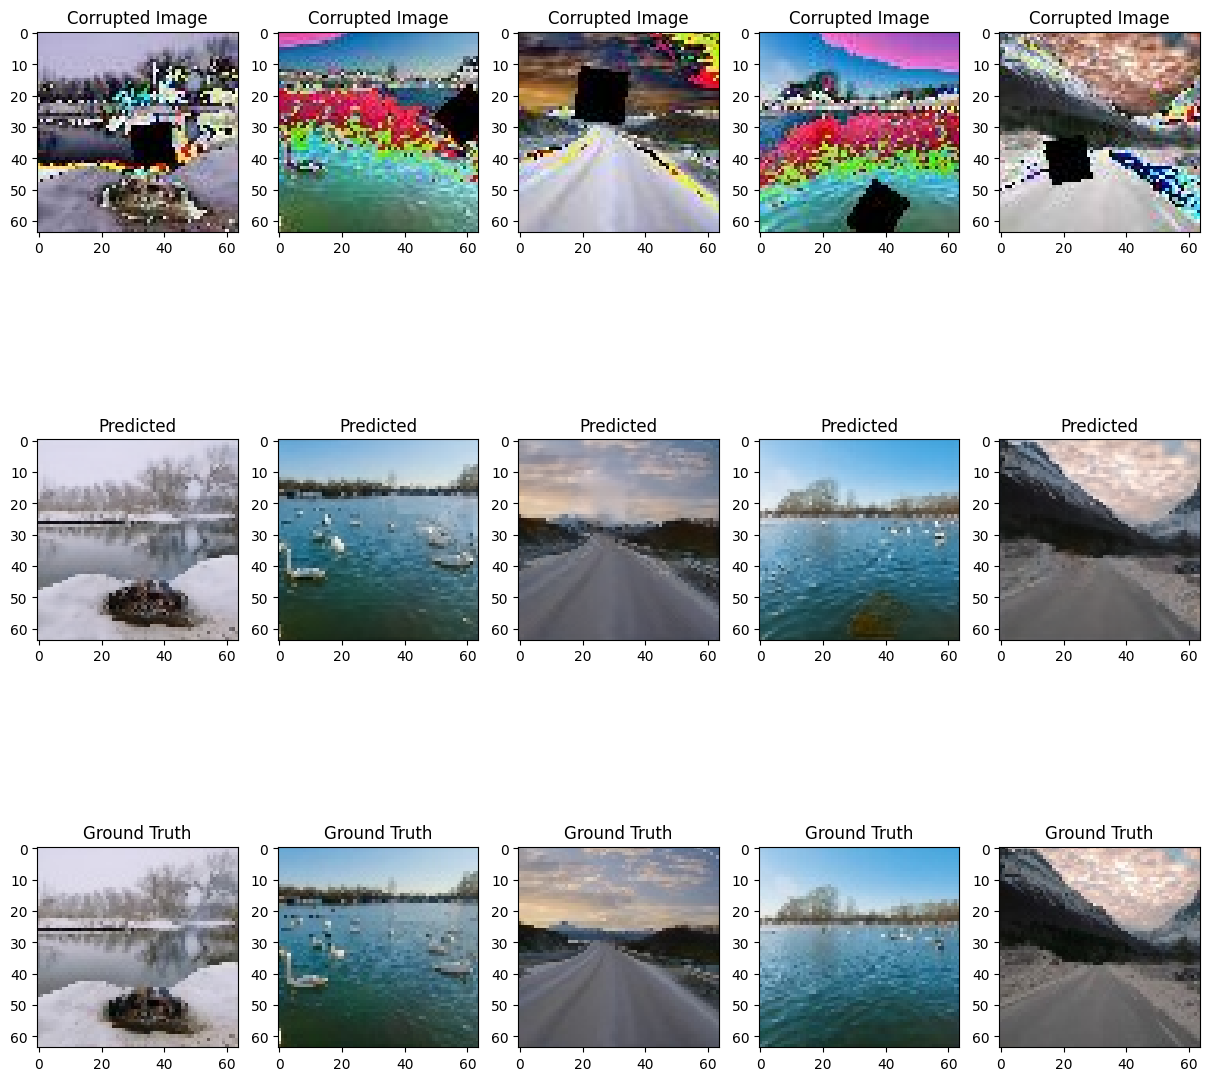

MSE     NRMSE       PSNR      SSIM
max   0.003464  0.059797  30.974572  0.963996
mean  0.001839  0.043395  27.529949  0.889963
min   0.000702  0.028266  24.466451  0.840695

MSE     NRMSE       PSNR      SSIM
mean  0.001839  0.043395  27.529949  0.889963

In [ ]:
evaluate(ddpm_model, test_loader, n=5)

## Experiments

## Functions

In [25]:
def train_validate_model(
    train_loader: DataLoader,
    val_loader: DataLoader,
    test_loader: DataLoader,
    max_epochs: int = 15,
    channels: list[int] = [32, 64, 128],
    timesteps: int = 1000,
    evaluate_batches_num: int = 5,
    beta_type: str | None = None
) -> pd.DataFrame:
    """
    Train and validate a model on the given datasets.

    Parameters
    ----------
    train_loader : DataLoader
        The DataLoader for the training dataset.
    val_loader : DataLoader
        The DataLoader for the validation dataset.
    test_loader : DataLoader
        The DataLoader for the test dataset, not used in this function.
    max_epochs : int, optional
        The maximum number of epochs for training. Default is 15.
    channels : list of int, optional
        The number of channels for each layer of the U-Net model. Default is [32, 64, 128].
    timesteps : int, optional
        The number of timesteps for the diffusion process. Default is 1000.
    evaluate_batches_num : int, optional
        The number of batches to evaluate on, not used in this function. Default is 5.
    beta_type : str or None, optional
        The type of beta schedule to use for the diffusion process. If None, a default schedule is used.
        Default is None.

    Returns
    -------
    pd.DataFrame
        A DataFrame with the computed metrics for each sample in the validation dataset. Currently,
        this function is configured to return the trained model instead of metrics DataFrame.
    """
    if beta_type is None:
        diffusion_model = Diffusion(timesteps=timesteps)
    else:
        diffusion_model = Diffusion(timesteps=timesteps, beta_type=beta_type)
    unet_model = UNetDDPM(channels=channels).to('cuda')
    ddpm_model = DDPM(unet_model, diffusion_model).to('cuda')

    trainer = pl.Trainer(
        devices=[0],
        max_epochs=max_epochs, 
        check_val_every_n_epoch=5,
        limit_val_batches=1,
        )

    trainer.fit(
        model=ddpm_model, 
        train_dataloaders=train_loader, 
        val_dataloaders=val_loader
        )
    
    # evaluate_metrics = evaluate(ddpm_model, test_loader, evaluate_batches_num)
    
    # metrics = evaluate_metrics.describe().loc[["mean"]]
    return ddpm_model


def plot_metrics(metrics_df: pd.DataFrame, title: str, metric: str) -> None:
    """
    Plot the computed metrics for each sample in the dataset.

    This function plots the computed metrics for each sample in the dataset
    as a box plot.

    Parameters
    ----------
    metrics_df : pd.DataFrame
        A DataFrame with the computed metrics for each sample in the dataset.
    title : str
        The title for the plot.
    metric : str
        The metric to use as X-ax label.
    """
    df = pd.concat(metrics_df.values(), keys=metrics_df.keys())
    df.index = df.index.droplevel(1)
    display(df)

    plt.style.use("ggplot")
    fig, axs = plt.subplots(2, 2, figsize=(12, 10))
    fig.suptitle(title, fontsize=12)

    for i, col in enumerate(df.columns):
        ax = axs[i//2, i%2]
        cmap = plt.get_cmap("brg")
        colors = cmap(np.linspace(0, 1, len(df[col])))
        ax.bar(df.index, df[col], color=colors)
        ax.set_title(col)
        ax.set_xlabel(metric)
        ax.set_ylabel(f"{col} Value")

    plt.tight_layout(rect=[0, 0, 1, 0.96])
    plt.show()

### Number of channels (number of parameters)

In [ ]:
channels_list = [[32, 64], [32, 64, 128], [64, 96, 128], [32, 64, 96, 128]]
channels_results = {}

for channels in channels_list:
    print(f"Channels: {channels}")
    channels_results[str(channels)] = train_validate_model(
        train_loader=train_loader,
        val_loader=val_loader,
        test_loader=test_loader,
        channels=channels,
        max_epochs=15,
        evaluate_batches_num=5,
    )

In [24]:
channels_results.keys()

dict_keys(['[32, 64]', '[32, 64, 128]', '[64, 96, 128]', '[32, 64, 96, 128]'])

In [25]:
with open('channels_results.pkl', 'wb') as file:
    # Use pickle.dump() to write the dictionary to the file
    pickle.dump(channels_results, file)

In [25]:
with open('channels_results.pkl', 'rb') as file:
    # Load the dictionary back from the pickle file
    test = pickle.load(file)

### Evaluate and plot test for number of channels


sampling loop

sampling loop

sampling loop

sampling loop

sampling loop


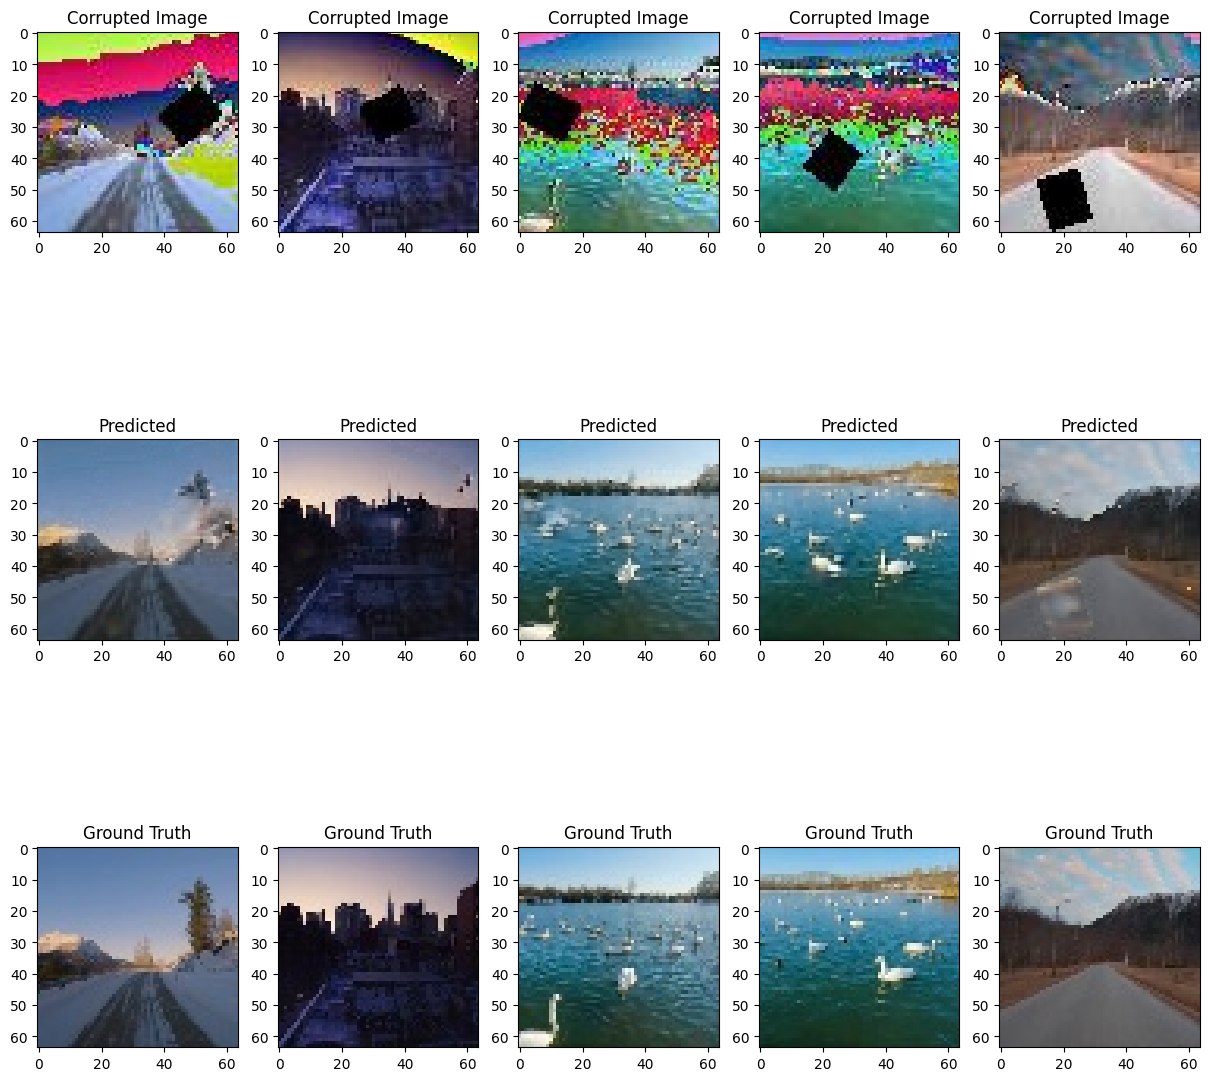

MSE     NRMSE       PSNR      SSIM
max   0.009935  0.100066  26.312434  0.836893
mean  0.005453  0.074738  22.755860  0.803339
min   0.001616  0.048348  19.994311  0.770649


sampling loop

sampling loop

sampling loop

sampling loop

sampling loop


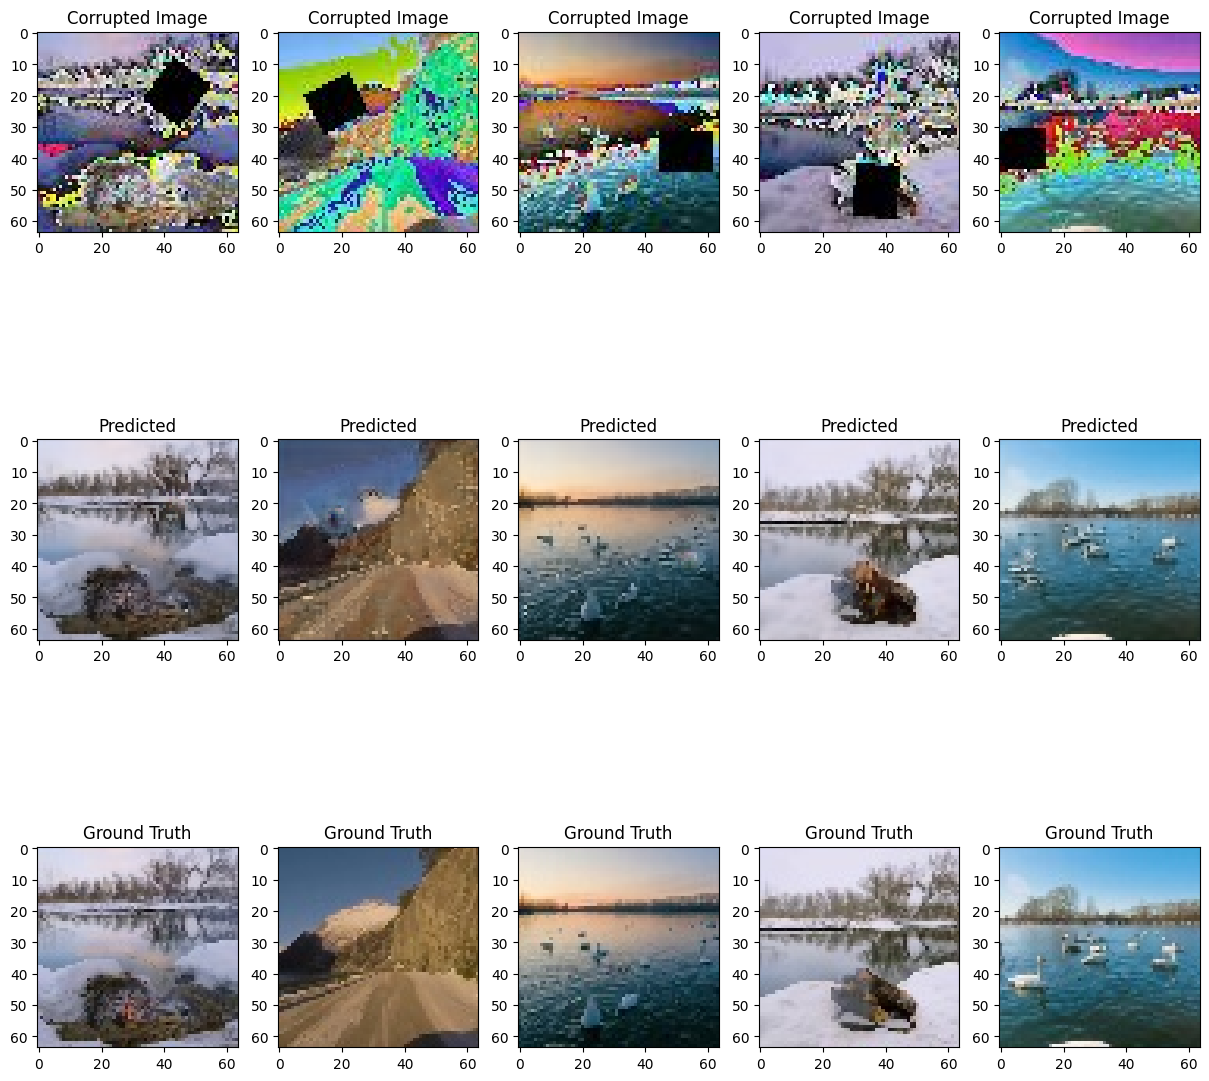

MSE     NRMSE       PSNR      SSIM
max   0.005243  0.084308  26.938942  0.939357
mean  0.003621  0.062869  24.279933  0.844038
min   0.001868  0.044983  21.482597  0.689717


sampling loop

sampling loop

sampling loop

sampling loop

sampling loop


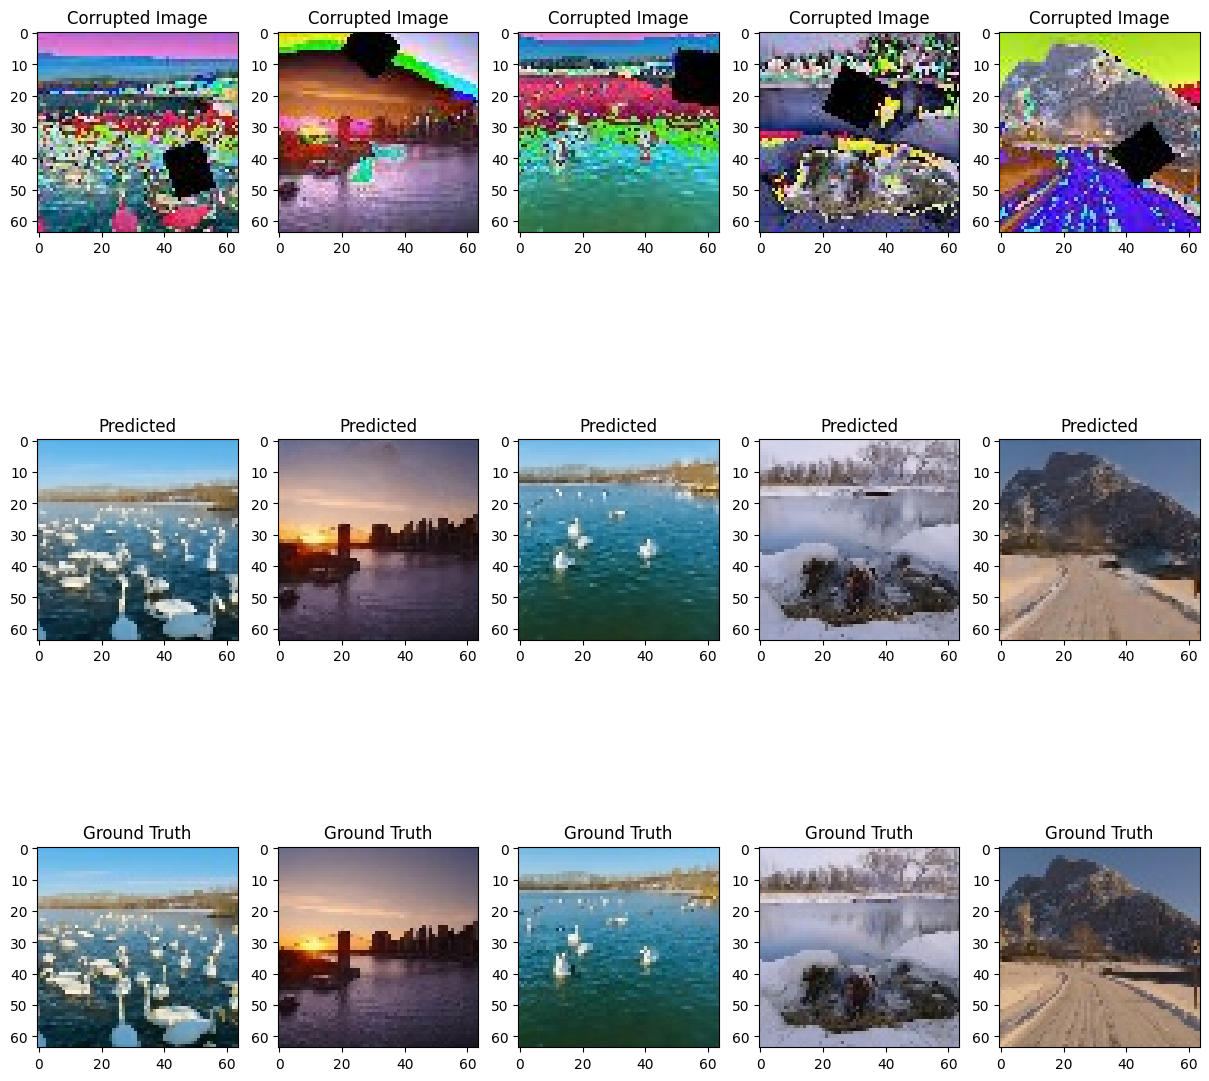

MSE     NRMSE       PSNR      SSIM
max   0.012077  0.109897  29.790709  0.940658
mean  0.004195  0.060709  25.220394  0.869721
min   0.001049  0.032394  19.180296  0.786736


sampling loop

sampling loop

sampling loop

sampling loop

sampling loop


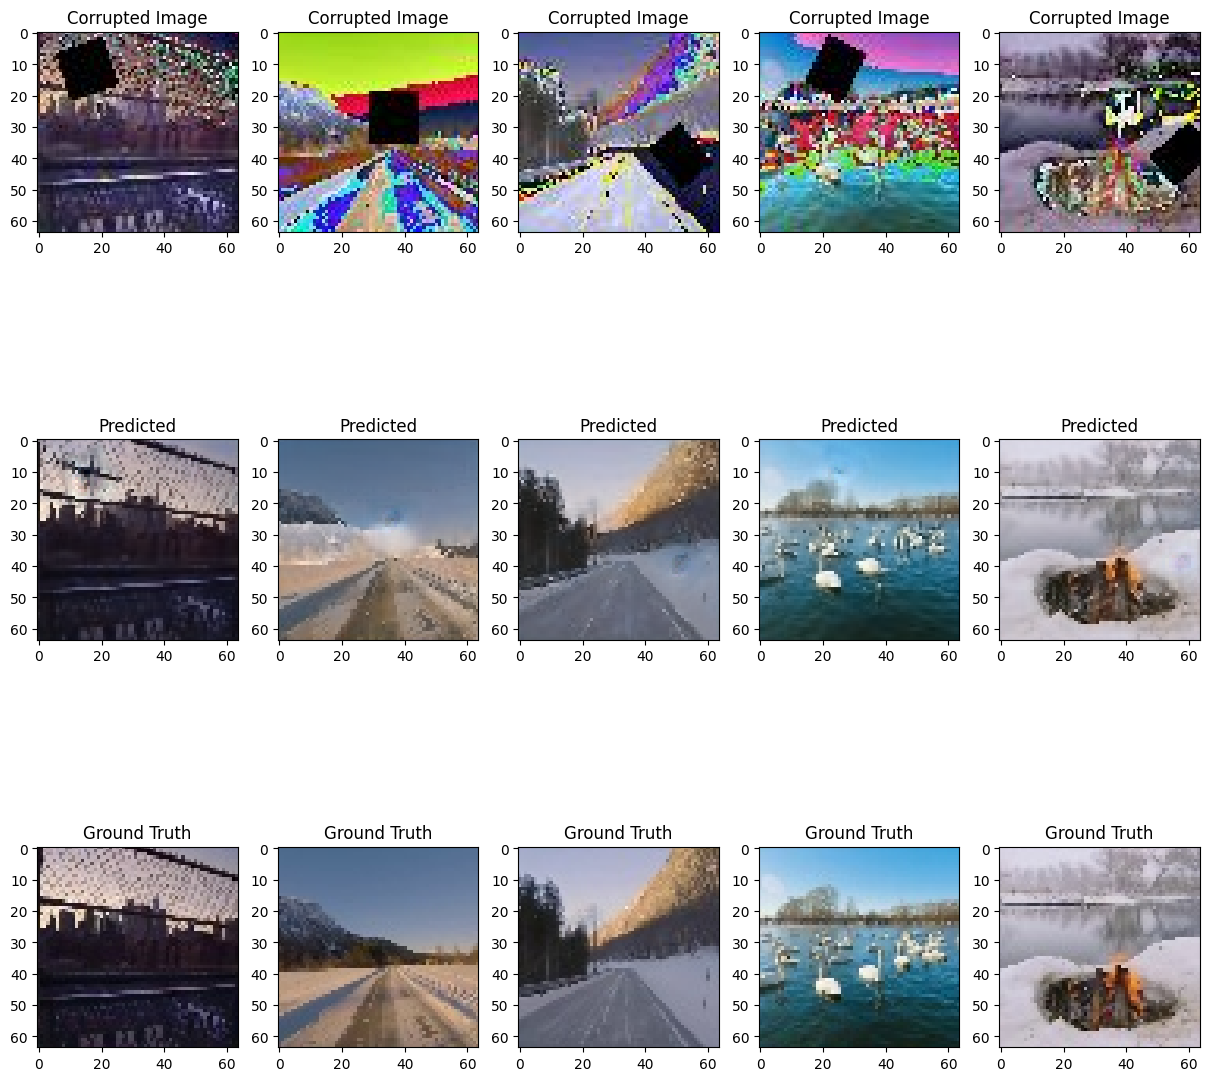

MSE     NRMSE       PSNR      SSIM
max   0.032636  0.219367  28.094817  0.935943
mean  0.010742  0.099748  21.562272  0.806010
min   0.001339  0.039378  13.176571  0.657242

In [ ]:
metrics = {}
for t in test:
    metrics[t] = evaluate(test[t], test_loader, 5).describe().loc[["mean"]]

MSE     NRMSE       PSNR      SSIM
[32, 64]           0.005453  0.074738  22.755860  0.803339
[32, 64, 128]      0.003621  0.062869  24.279933  0.844038
[64, 96, 128]      0.004195  0.060709  25.220394  0.869721
[32, 64, 96, 128]  0.010742  0.099748  21.562272  0.806010

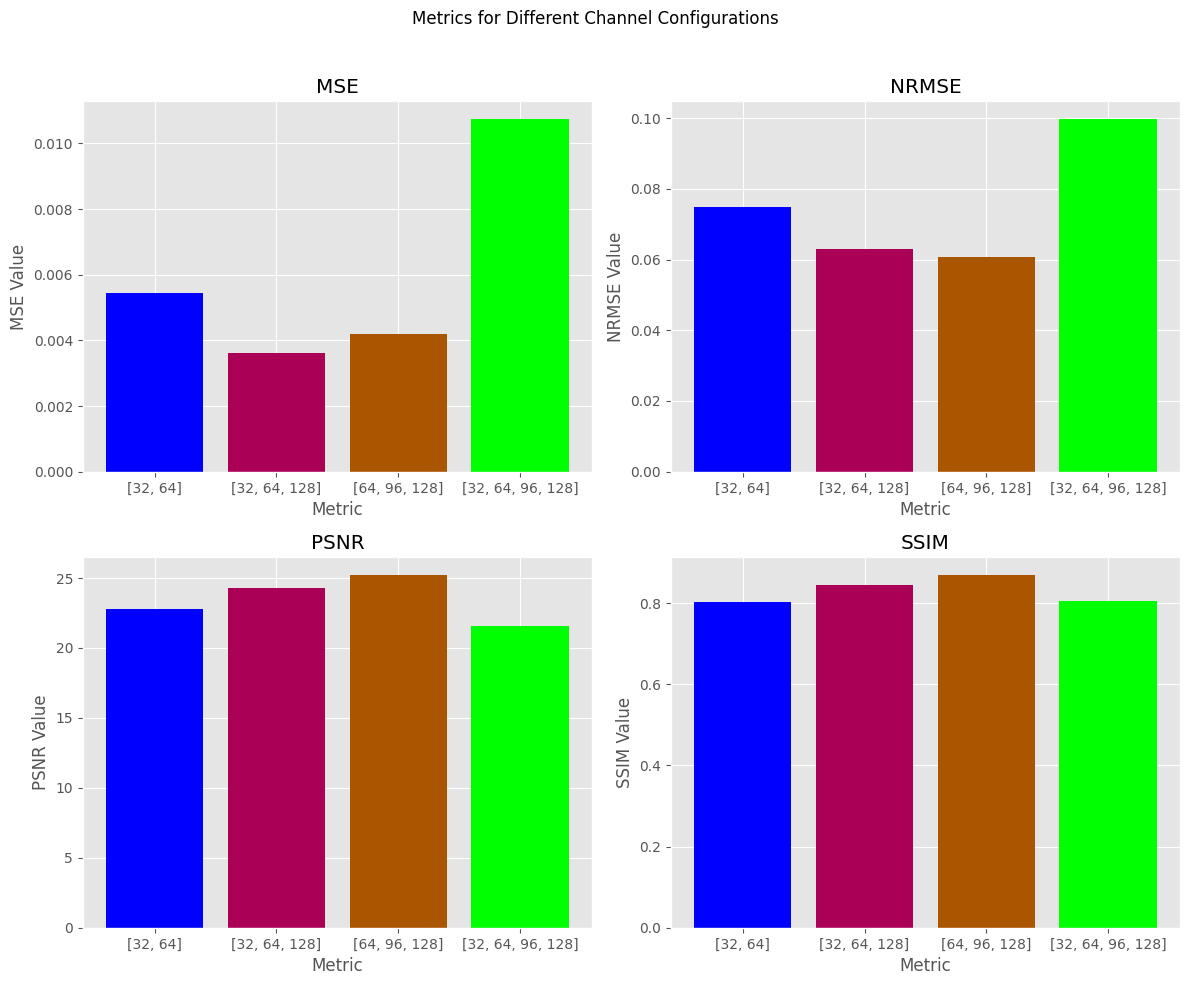

In [54]:
plot_metrics(metrics, "Metrics for Different Channel Configurations", "Metric")


### Beta type

In [ ]:
beta_types = ['linear', 'cosine']
beta_results = {}

for beta in beta_types:
    print(f"Beta type: {beta}")
    beta_results[beta] = train_validate_model(
        train_loader=train_loader,
        val_loader=val_loader,
        test_loader=test_loader,
        channels=[64, 96, 128],
        max_epochs=15,
        evaluate_batches_num=5,
        beta_type=beta
    )

In [27]:
with open('beta_results.pkl', 'wb') as file:
    # Use pickle.dump() to write the dictionary to the file
    pickle.dump(beta_results, file)

In [28]:
with open('beta_results.pkl', 'rb') as file:
    # Load the dictionary back from the pickle file
    test_beta = pickle.load(file)

### Evaluate and plot test for Beta type


sampling loop

sampling loop

sampling loop

sampling loop

sampling loop


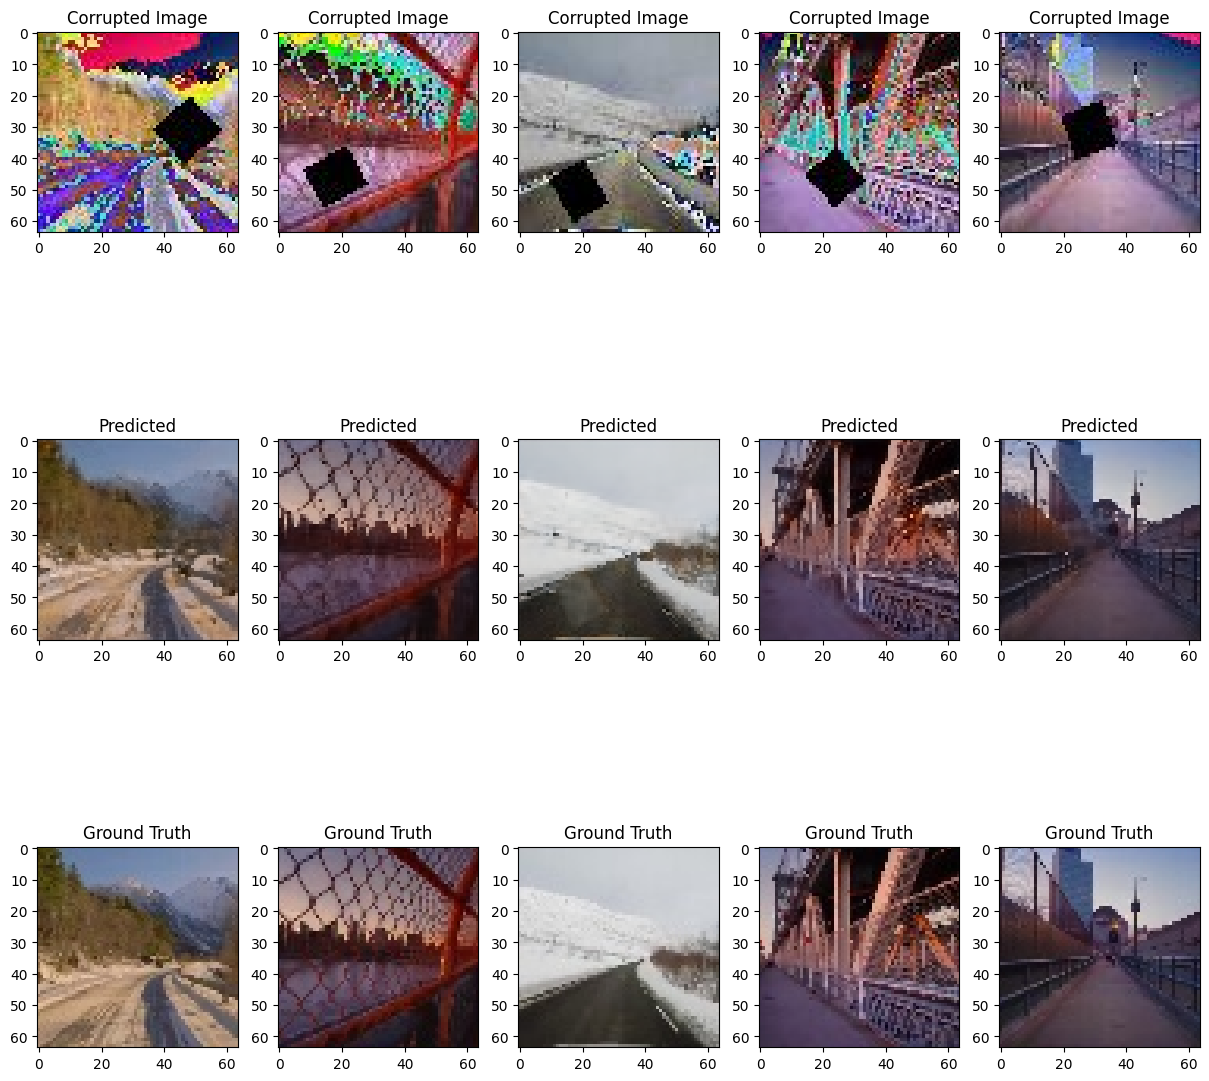

MSE     NRMSE       PSNR      SSIM
max   0.006554  0.086375  24.933213  0.875684
mean  0.003872  0.066914  23.584375  0.834741
min   0.002304  0.056668  21.272205  0.806592


sampling loop

sampling loop

sampling loop

sampling loop

sampling loop


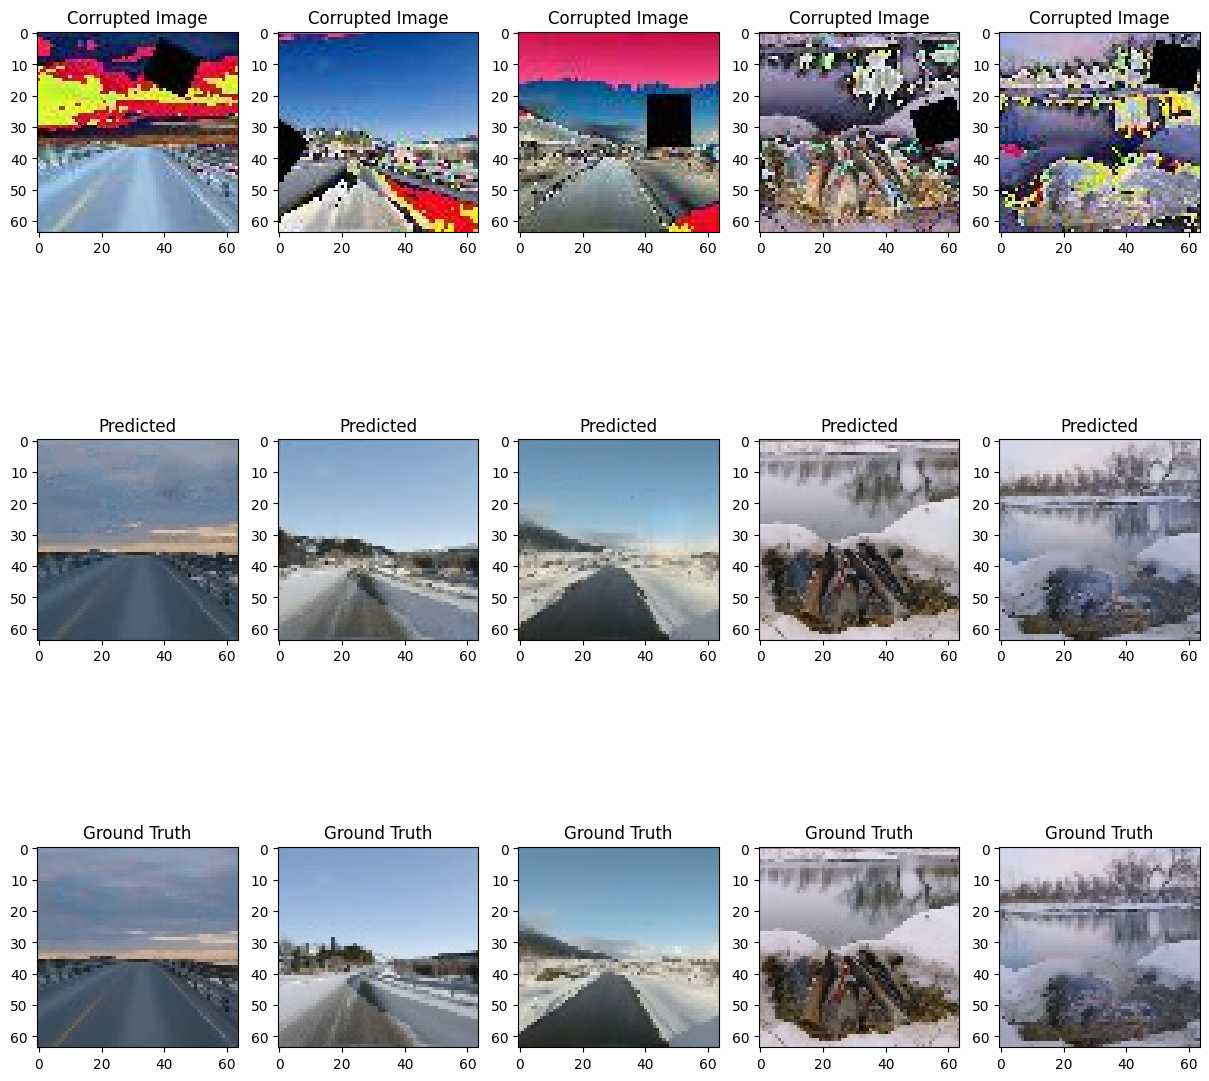

MSE     NRMSE       PSNR      SSIM
max   0.006713  0.087420  30.921484  0.969946
mean  0.002762  0.054888  25.958137  0.899143
min   0.000747  0.028440  21.167746  0.839144

In [29]:
beta_metrics = {}
for t in test_beta:
    beta_metrics[t] = evaluate(test_beta[t], test_loader, 5).describe().loc[["mean"]]

MSE     NRMSE       PSNR      SSIM
linear  0.003872  0.066914  23.584375  0.834741
cosine  0.002762  0.054888  25.958137  0.899143

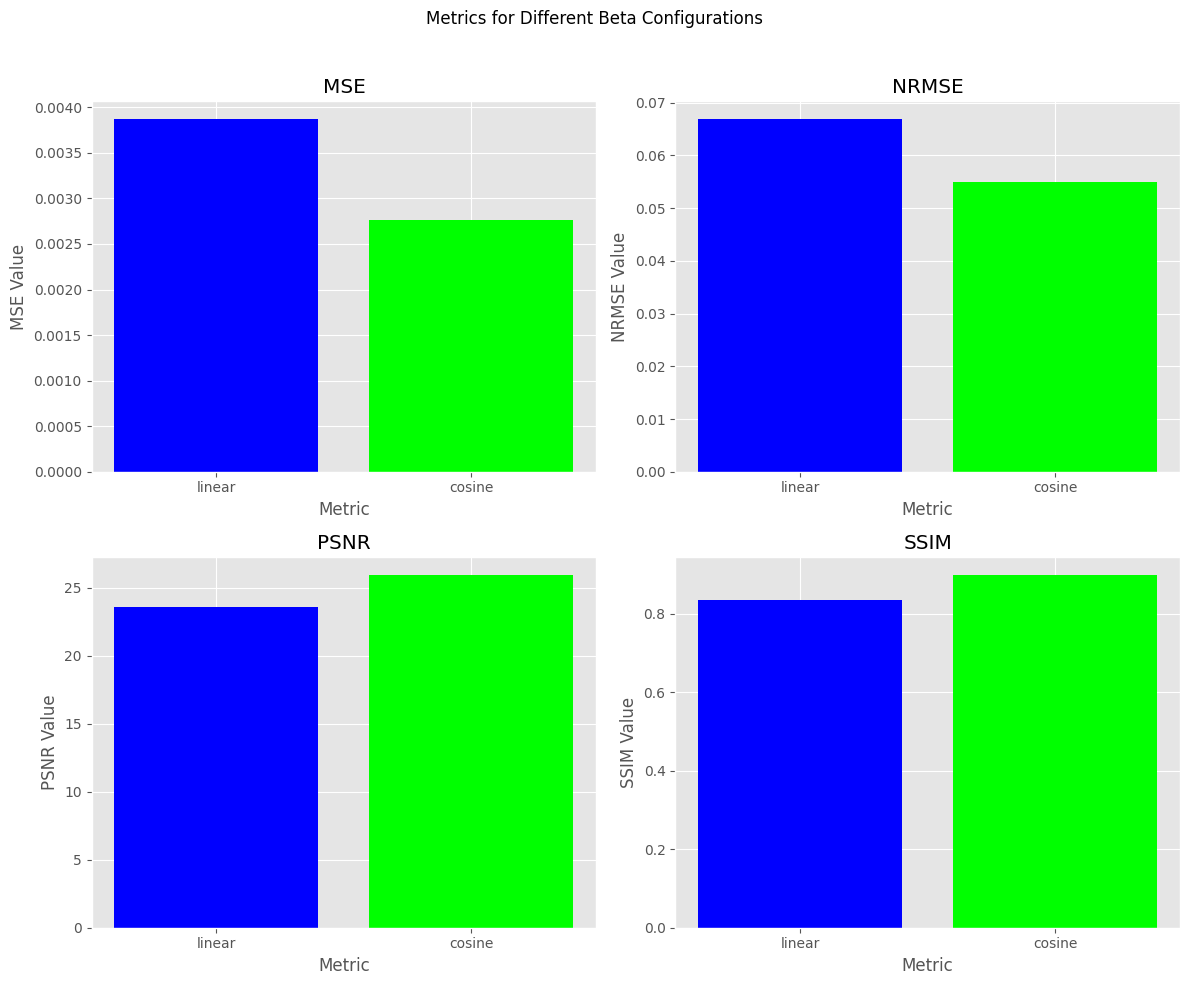

In [30]:
plot_metrics(beta_metrics, "Metrics for Different Beta Configurations", "Metric")